# 01 – EDA: Bike Sharing Demand

Bu notebook, BikeSharing-ML-Pipeline projesi için keşifsel veri analizi (EDA) adımlarını içerir.

Amaç:

- Veri setinin genel yapısını anlamak
- Hedef değişkenin (count) dağılımını incelemek
- Zaman, hava durumu ve takvim değişkenleri ile talep ilişkisini görmek
- Sonraki aşamalarda kullanılacak feature engineering fikirlerini çıkarmak


In [2]:
import os
from pathlib import Path

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats

import warnings
warnings.filterwarnings("ignore")

plt.style.use("ggplot")
pd.set_option("display.max_columns", 50)

DATA_PATH = Path("../data/raw")
FIGURES = Path("../figures")
FIGURES.mkdir(parents=True, exist_ok=True)

train_path = DATA_PATH / "train.csv"
test_path = DATA_PATH / "test.csv"

print("Kütüphaneler yüklendi")


Kütüphaneler yüklendi


In [3]:
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)

print("Train shape:", train.shape)
print("Test shape:", test.shape)

train.head()



Train shape: (10886, 12)
Test shape: (6493, 9)


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


- Test setinde daha az sütun olması beklediğim bir durum, çünkü Kaggle yarışmada target kolonları yalnızca train’de bulunur.  
- datetime kolonunda saatler düzenli şekilde (1 saat aralıkla artıyor)
**- season kolonu kaggle açıklaması( 1=ilkbahar, 2=yaz , 3=sonbahar , 4=kış şeklinde)**
- holiday tatil günü kolonuyla tatil günleri için FE üretilebilir
- workingday işe gidiş geliş saati ile ilgili FE üretilebilir
**- weather kolonu kaggle açıklaması(1 = Açık, bulutsuz , 2 = Sisli, bulutlu, parçalı bulutlu, 3 = Hafif kar, hafif yağmur, şiddetli rüzgar,4 = Ağır yağış, gök gürültülü fırtına, ağır kar )**
- temp sıcaklık kolonu kiralama zamanları ile ilgili kullanılabilir
- windspeed rüzgar hızı kolonu ilk 5 kolonda hep 0 görünüyor, hatalı gibi
- casual geçici kullanıcı kolonu
- registered kayıtlı kullanıcı sayısı kolonu
- count toplam kiralama sayısı


In [44]:
train.info()
train.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

**- eksik bir değer yok.**  
- count hedef değişken  
**- casual ve registered test setinde yok, lakage oluşturacağı için modelde dikkat edilmesi gereken kolonlar**  
- casual geçici kullanıcı kolonu
- registered kayıtlı kullanıcı sayısı kolonu
- kolon tipleri temiz bir yapıya sahip


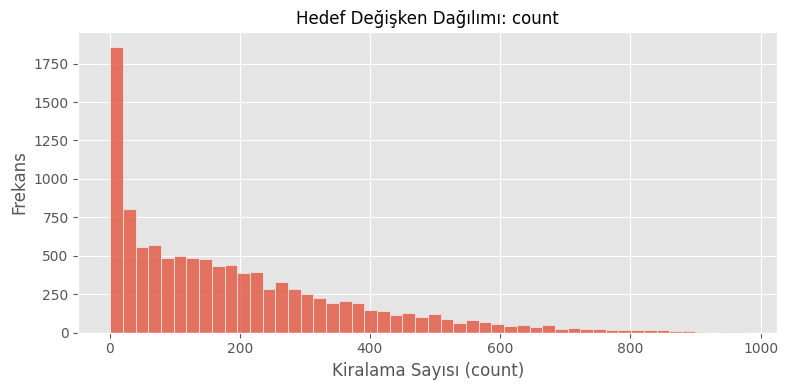

np.float64(1.2420662117180776)

In [11]:


fig, ax = plt.subplots(figsize=(8, 4))
sns.histplot(train["count"], bins=50, kde=False, ax=ax)
ax.set_title("Hedef Değişken Dağılımı: count", fontsize=12)
ax.set_xlabel("Kiralama Sayısı (count)")
ax.set_ylabel("Frekans")
plt.tight_layout()
plt.savefig(FIGURES / "target_count_distribution.png")
plt.show()

train["count"].skew()

- dağılım sağa çarpık vaziyette (dağılım kuyruk yönüne göredir)
- skewness metriği pozitif olması da bunu destekliyor.
- 0-50 kiralama aralığı en yüksek 
- 50-100 arası yoğun
- 300-1000 arası seyrek
çoğu saat az kiralamayla geçiyor.  
- düşük olsa da tamamen yok değil, talep durumlara göre(zaman,hava durum gibi değişkenlerle) değişiklik gösteriyor.

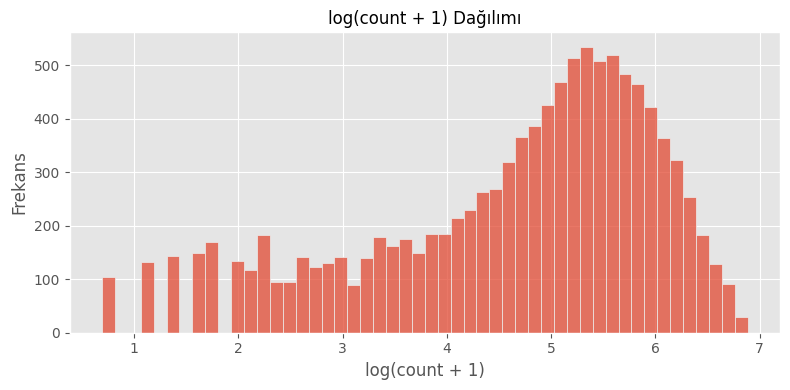

In [7]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.histplot(np.log1p(train["count"]), bins=50, kde=False, ax=ax)
ax.set_title("log(count + 1) Dağılımı", fontsize=12)
ax.set_xlabel("log(count + 1)")
ax.set_ylabel("Frekans")
plt.tight_layout()
plt.savefig(FIGURES / "target_count_log_distribution.png")
plt.show()


Çarpık (skewed) dağılımı daha dengeli hale getirmek için log dönüşümü yapıyorum: 

- dağılım normalleşmiş görünüyor
- sağ ve sol taraflarda neredeyse dengeli bir düşüş var.
- dağılım orta bölgede yoğun (5-6) ve güçlü bir peak var

In [12]:
train["datetime"] = pd.to_datetime(train["datetime"])
test["datetime"] = pd.to_datetime(test["datetime"])

for df in [train, test]:
    df["year"] = df["datetime"].dt.year
    df["month"] = df["datetime"].dt.month
    df["day"] = df["datetime"].dt.day
    df["hour"] = df["datetime"].dt.hour
    df["dayofweek"] = df["datetime"].dt.dayofweek  
    df["is_weekend"] = df["dayofweek"].isin([5, 6]).astype(int)

train[["datetime", "year", "month", "day", "hour", "dayofweek", "is_weekend"]].head()


,datetime,year,month,day,hour,dayofweek,is_weekend
0,2011-01-01 00:00:00,2011,1,1,0,5,1
1,2011-01-01 01:00:00,2011,1,1,1,5,1
2,2011-01-01 02:00:00,2011,1,1,2,5,1
3,2011-01-01 03:00:00,2011,1,1,3,5,1
4,2011-01-01 04:00:00,2011,1,1,4,5,1


tüm satırlar 2011 yılı, data 2011-2012' yılınınmış... 

- zaman bileşenleri başarılı şekilde çıkarıldı
- hour,dayofweek,isweekend,month gibi featureler modelde büyük etkisi olacak gibi

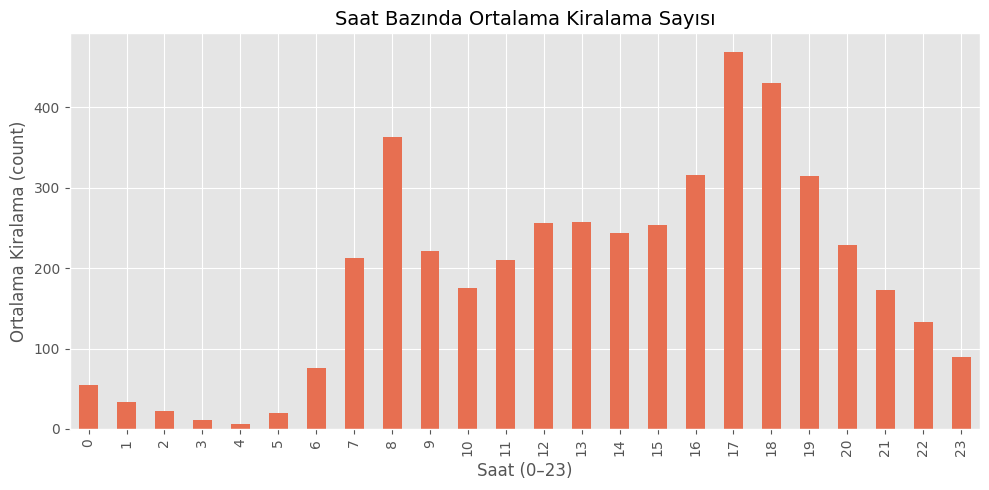

In [13]:
hourly = train.groupby("hour")["count"].mean()

fig, ax = plt.subplots(figsize=(10, 5))
hourly.plot(kind="bar", ax=ax, color="#e76f51")
ax.set_title("Saat Bazında Ortalama Kiralama Sayısı", fontsize=14)
ax.set_xlabel("Saat (0–23)")
ax.set_ylabel("Ortalama Kiralama (count)")
plt.tight_layout()
plt.savefig(FIGURES / "count_by_hour.png")
plt.show()


- gece 12 ile sabah 5 arası ölü saater

işe gidiş paterni:
- sabah 7 ile 9 arasında güçlü bir artış var
- 8'de büyük bir sıçrama var
- öğlen 11 ve 3 arasında stabil bir orta seviye var, 200+ dalga mevcut

işten dönüş paterni:
- akşam 5 ile 6 en yüksek peak 450+ talep var
- akşam 7 ile 10 arası yavaş bi düşüş

sonrasında 100- altına düşüyor

ek olarak: 
- hour en güçlü FE'lerden birisi
- model seçimi için güçlü sinyaller verdi


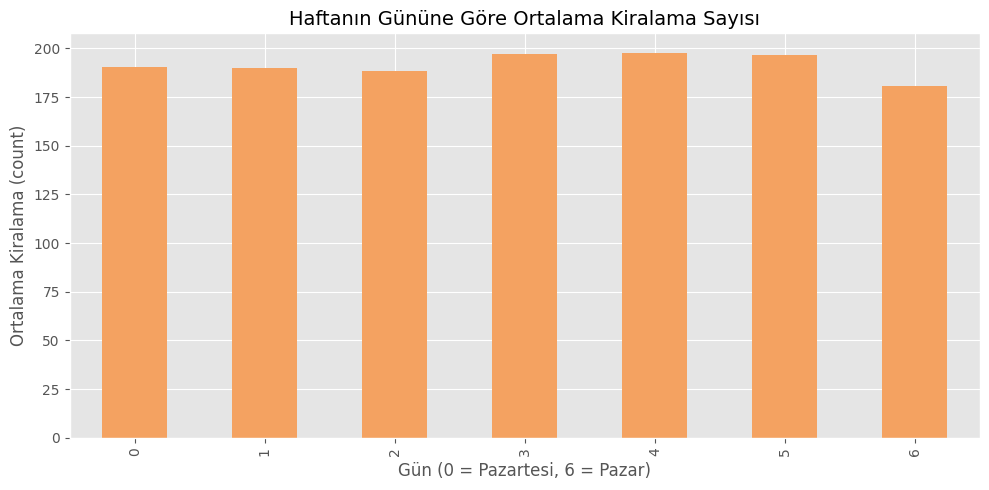

In [14]:
dow = train.groupby("dayofweek")["count"].mean()

fig, ax = plt.subplots(figsize=(10, 5))
dow.plot(kind="bar", ax=ax, color="#f4a261")
ax.set_title("Haftanın Gününe Göre Ortalama Kiralama Sayısı", fontsize=14)
ax.set_xlabel("Gün (0 = Pazartesi, 6 = Pazar)")
ax.set_ylabel("Ortalama Kiralama (count)")
plt.tight_layout()
plt.savefig(FIGURES / "count_by_dayofweek.png")
plt.show()


- günler arasındaki fark neredeyse eşit
- en yüksek günler perşembe-cuma ve cumartesi
- en belirgin düşüş pazar günü (insanların izinli oldukları gün) workingday etkisinden sanırım
- dayofweek tek başına güçlü bir sinyal değil, hour+workingday+is_weekend birleşince etkiyi merak ediyorum

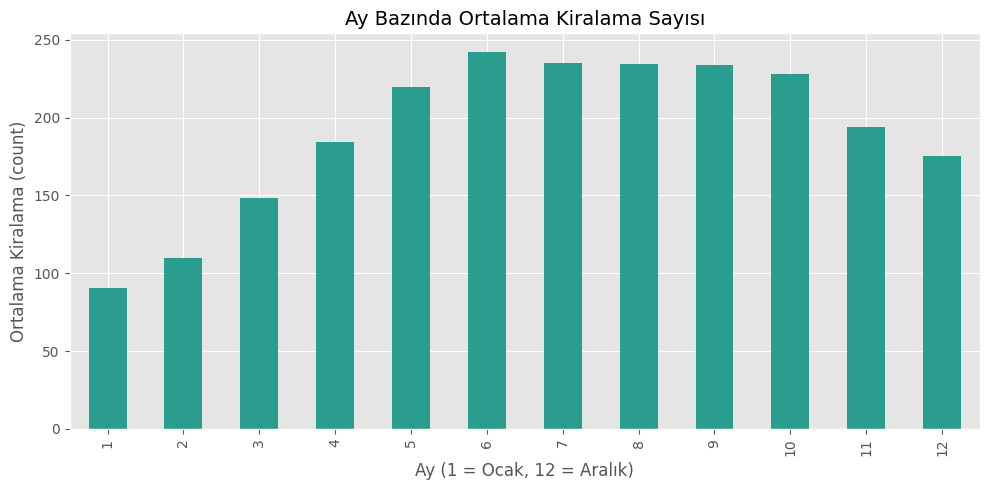

In [15]:
monthly = train.groupby("month")["count"].mean()

fig, ax = plt.subplots(figsize=(10, 5))
monthly.plot(kind="bar", ax=ax, color="#2a9d8f")
ax.set_title("Ay Bazında Ortalama Kiralama Sayısı", fontsize=14)
ax.set_xlabel("Ay (1 = Ocak, 12 = Aralık)")
ax.set_ylabel("Ortalama Kiralama (count)")
plt.tight_layout()
plt.savefig(FIGURES / "count_by_month.png")
plt.show()


* Ay bazındaki analiz bisiklet kullanımının güçlü bir mevsimsel yapıya sahip olduğunu göstermektedir. 
* Talep kış aylarında minimum seviyedeyken, yaz ve ilkbahar-sonbahar dönemlerinde belirgin şekilde yükselmektedir. 
* Haziran–Ağustos dönemi yılın en yüksek talep dönemidir. 
* Bu durum month ve season değişkenlerinin modelde önemli birer sinyal olacağını göstermektedir

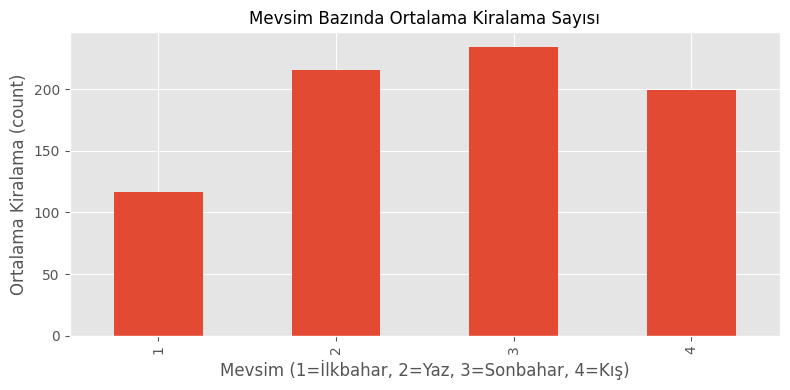

In [10]:
seasonal = train.groupby("season")["count"].mean()

fig, ax = plt.subplots(figsize=(8, 4))
seasonal.plot(kind="bar", ax=ax)
ax.set_title("Mevsim Bazında Ortalama Kiralama Sayısı", fontsize=12)
ax.set_xlabel("Mevsim (1=İlkbahar, 2=Yaz, 3=Sonbahar, 4=Kış)")
ax.set_ylabel("Ortalama Kiralama (count)")
plt.tight_layout()
plt.savefig(FIGURES / "count_by_season.png")
plt.show()


### Mevsim Bazında Talep (season)

Bu grafik, talebin yıl içinde mevsimsel olarak değiştiğini gösterir.
Ay bazlı analizde gördüğümüz mevsimsellik burada daha kompakt şekilde özetlenir.

- Mevsimler arası farkların belirgin olması beklenir (özellikle kış vs yaz).
- Season değişkeni, month değişkenine göre daha “genel” bir mevsim sinyali taşır.
- İleride modelleme aşamasında month + season birlikte değerlendirilebilir.
